<a href="https://colab.research.google.com/github/cshmzin/nlp-code/blob/main/bert%E5%91%BD%E5%90%8D%E5%AE%9E%E4%BD%93%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 获取数据
import json

train_data = []
dev_data = []
test_data = []

for line in open('train.json','r',encoding='UTF-8'):
    train_data.append(json.loads(line))

for line in open('dev.json','r',encoding='UTF-8'):
    dev_data.append(json.loads(line))

for line in open('test.json','r',encoding='UTF-8'):
    test_data.append(json.loads(line))


print(f'数量：train：{len(train_data)},dev：{len(dev_data)},test：{len(test_data)}')
print(train_data[0])
print(dev_data[0])
print(test_data[0])


数量：train：10748,dev：1343,test：1345
{'text': '浙商银行企业信贷部叶老桂博士则从另一个角度对五道门槛进行了解读。叶老桂认为，对目前国内商业银行而言，', 'label': {'name': {'叶老桂': [[9, 11]]}, 'company': {'浙商银行': [[0, 3]]}}}
{'text': '彭小军认为，国内银行现在走的是台湾的发卡模式，先通过跑马圈地再在圈的地里面选择客户，', 'label': {'address': {'台湾': [[15, 16]]}, 'name': {'彭小军': [[0, 2]]}}}
{'id': 0, 'text': '四川敦煌学”。近年来，丹棱县等地一些不知名的石窟迎来了海内外的游客，他们随身携带着胡文和的著作。'}


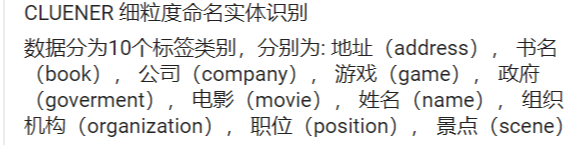


In [5]:
print(dev_data[66])

{'text': '王府井书店北京市东城区王府井大街218号', 'label': {'address': {'王府井书店': [[0, 4]], '北京市东城区王府井大街218号': [[5, 19]]}}}


In [51]:
#上图为标签类别
#需要构建标签
import re

label_type = {'o':0,'address':1,'book':2,'company':3,'game':4,'government':5,'movie':6,'name':7,'organization':8,'position':9,'scene':10}

def decode_label(d):
  text_len = len(d['text'])
  label = [0]*text_len
  types = d['label'].keys()
  for t in types:
    values = d['label'][t].values()
    si = [v for value in values for v in value]
    for i in si:
      for j in range(i[0],i[1]+1):
        label[j] = label_type[t]
  return label


def transfrom_data(data,mode):
  data_texts = [re.sub('\d','&',d['text']) for d in data]
  
  if mode == 'train':
    data_labels = []
    for d in data:
      data_labels.append(decode_label(d))
    return (data_texts,data_labels)
  
  else:
    return data_texts 

train_texts,train_labels = transfrom_data(train_data,'train')
dev_texts,dev_labels = transfrom_data(dev_data,'train')
test_texts = transfrom_data(train_data,'test')

print(train_texts[0])
print(train_labels[0])
print(dev_texts[66])
print(dev_labels[66])
print(test_texts[66])

    

浙商银行企业信贷部叶老桂博士则从另一个角度对五道门槛进行了解读。叶老桂认为，对目前国内商业银行而言，
[3, 3, 3, 3, 0, 0, 0, 0, 0, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
王府井书店北京市东城区王府井大街&&&号
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
前几年，香港贸易发展局数次的组织寰宇娱乐、骄阳电影、美亚电影、寰亚综艺、东方电影、


In [52]:
! pip install transformers
from transformers import BertTokenizer
from IPython.display import clear_output

# 使用bert的tokenizer将文字转化成数字。
PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定为中文
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
clear_output()

train_ids = []
dev_ids = []
test_ids = []
for train_text in train_texts:
  train_ids.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text)))

for dev_text in dev_texts:
  dev_ids.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(dev_text)))

for test_text in test_texts:
  test_ids.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(test_text)))

print(train_ids[0])
print(dev_texts[66])
print(dev_labels[66])

  
    

[3851, 1555, 7213, 6121, 821, 689, 928, 6587, 6956, 1383, 5439, 3424, 1300, 1894, 1156, 794, 1369, 671, 702, 6235, 2428, 2190, 758, 6887, 7305, 3546, 6822, 6121, 749, 6237, 6438, 511, 1383, 5439, 3424, 6371, 711, 8024, 2190, 4680, 1184, 1744, 1079, 1555, 689, 7213, 6121, 5445, 6241, 8024]
王府井书店北京市东城区王府井大街&&&号
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [91]:
import torch
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence

MaxLen = 40
class NewDataset(Dataset):
    def __init__(self,ids,labels):
        self.ids = ids
        self.labels = labels
        self.len = len(ids)

    def __getitem__(self, item):
        tokens_tensor = torch.tensor(self.ids[item])
        label_tensor = torch.tensor(self.labels[item])
        return (tokens_tensor,label_tensor)

    def __len__(self):
        return self.len

trainset = NewDataset(train_ids,train_labels)
devset = NewDataset(dev_ids,dev_labels)
BATCH_SIZE = 64
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    label_tensors = [s[1] for s in samples]


    # zero pad 到同一序列长度
    one = [0]
    tokens_tensors = pad_sequence(tokens_tensors,batch_first=True)
    label_tensors = pad_sequence(label_tensors,batch_first=True,padding_value=0)

    if len(tokens_tensors[0]) != 50:
      tokens_tensors = torch.tensor([t + one for t in tokens_tensors.numpy().tolist()])
    if len(label_tensors[0]) != 50: 
      label_tensors = torch.tensor([t + one for t in label_tensors.numpy().tolist()])
    # attention masks，将 tokens_tensors 不为 zero padding 的位置设为1
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, masks_tensors, label_tensors


trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,collate_fn=create_mini_batch,drop_last=False)
devloader = DataLoader(trainset,batch_size=BATCH_SIZE,collate_fn=create_mini_batch,drop_last=False)


In [92]:
from transformers import BertForTokenClassification
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=17)
model.cuda()

model.train()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
Epochs = 10
for epoch in range(Epochs):
    losses = 0.0
    for data in trainloader:
        tokens_tensors, masks_tensors, label_tensors = [t.cuda() for t in data]
        optimizer.zero_grad()
        outputs = model(input_ids = tokens_tensors,attention_mask = masks_tensors,labels = label_tensors)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(losses)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

207.43179869651794
164.4600505232811
132.0904682278633
97.37582990527153
87.01311540603638
78.10394242405891
71.76738655567169
65.9089749455452
60.912592858076096


In [143]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

nb_eval_steps = 0
model.eval()
eval_loss,eval_accuracy = 0,0
predictions , true_labels = [], []

for data in devloader:
    tokens_tensors, masks_tensors, label_tensors = [t.cuda() for t in data]
    with torch.no_grad():
        outputs = model(input_ids=tokens_tensors, attention_mask=masks_tensors, labels=label_tensors)
        loss = outputs[0]
        preds = model(input_ids=tokens_tensors, attention_mask=masks_tensors)

    for pred,label_tensor in zip(preds[0],label_tensors):
      logit = pred.detach().cpu().numpy()#detach的方法，将variable参数从网络中隔离开，不参与参数更新
      label_ids = label_tensor.cpu().numpy()

      predictions.extend(np.argmax(logit, axis=1))
      true_labels.append(label_ids)
      # 计算accuracy 和 loss
      tmp_eval_accuracy = flat_accuracy(logit, label_ids)

      eval_loss += loss.mean().item()
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Validation loss: 0.28883913095040886
Validation Accuracy: 0.8734573874208609


In [159]:

from sklearn.metrics import f1_score
pred_tags = list(np.array(predictions).flatten())
valid_tags = list(np.array(true_labels).flatten())
print(pred_tags[0:20])
print(valid_tags[0:20])
print("F1-Score: {}".format(f1_score(pred_tags,valid_tags,average='weighted')))#传入的是具体的tag

[3, 3, 3, 3, 0, 0, 0, 3, 3, 9, 9, 9, 7, 0, 0, 0, 0, 0, 0, 0]
[3, 3, 3, 3, 0, 0, 0, 0, 0, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0]
F1-Score: 0.8672966293134791


In [189]:
text = '普京是俄罗斯的总统'
test_tokens = tokenizer.tokenize(text)
test_ids = tokenizer.convert_tokens_to_ids(test_tokens)
test_tokens_tensor = torch.tensor(test_ids)
test_tokens_tensor = test_tokens_tensor

test_masks_tensor = torch.zeros(test_tokens_tensor.shape, dtype=torch.long)
test_masks_tensor = test_masks_tensor.masked_fill(test_tokens_tensor != 0, 1)

outputs = model(input_ids=test_tokens_tensor.unsqueeze(0).cuda(),attention_mask=test_masks_tensor.unsqueeze(0).cuda())
logits = outputs[0]
preds = []
for logit in logits:
  preds.extend(np.argmax(logit.detach().cpu().numpy(), axis=1))

inverse_dict=dict([val,key] for key,val in label_type.items())
preds = [inverse_dict[i] for i in preds]

print(test_tokens)
print(preds)



['普', '京', '是', '俄', '罗', '斯', '的', '总', '统']
['company', 'company', 'company', 'address', 'address', 'address', 'o', 'position', 'position']
